# 1. Data Cleaning

#### Let's start with importing packages that we will use in this project.

In [111]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

#### Let's import the post codes that already collected in a txt file.
#### We are going to use these post codes to get the coordinates of the area. Let's import Houston's first.

In [12]:
# txt file of Houston post code
hou_file = open("hou_post_code.txt", "r")
hou_string = ""
if hou_file.mode == "r":
    hou_string = hou_file.read()

# a string contains all post codes in Houston, Texas
hou_string

'77001,77002,77003,77004,77005,77006,77007,77008,77009,77010,77011,77012,77013,77014,77015,77016,77017,77018,77019,77020,77021,77022,77023,77024,77025,77026,77027,77028,77029,77030,77031,77032,77033,77034,77035,77036,77037,77038,77039,77040,77041,77042,77043,77044,77045,77046,77047,77048,77049,77050,77051,77052,77053,77054,77055,77056,77057,77058,77059,77060,77061,77062,77063,77064,77065,77066,77067,77068,77069,77070,77071,77072,77073,77074,77075,77076,77077,77078,77079,77080,77081,77082,77083,77084,77085,77086,77087,77088,77089,77090,77091,77092,77093,77094,77095,77096,77098,77099,77201,77202,77203,77204,77205,77206,77207,77208,77209,77210,77212,77213,77215,77216,77217,77218,77219,77220,77221,77222,77223,77224,77225,77226,77227,77228,77229,77230,77231,77233,77234,77235,77236,77237,77238,77240,77241,77242,77243,77244,77245,77248,77249,77251,77252,77253,77254,77255,77256,77257,77258,77259,77261,77262,77263,77265,77266,77267,77268,77269,77270,77271,77272,77273,77274,77275,77277,77279,772

In [13]:
# use comma as the separator
hou_postcode = hou_string.split(',')
hou_postcode[:8]  # the list contains all post codes in Houston

['77001', '77002', '77003', '77004', '77005', '77006', '77007', '77008']

#### Now we have all the post codes in Houston, we will do the same thing for Dallas'.

In [14]:
dal_file = open("dal_post_code.txt", "r") # txt file of Dallas and nearby cities' post code
dal_string = ""
if dal_file.mode == "r":
    dal_string = dal_file.read()

dal_postcode = dal_string.split(',')
dal_postcode[:8] # the list contains all post codes in Dallas

['75201', '75202', '75203', '75204', '75205', '75206', '75207', '75208']

#### Now let's use the post codes to get the coordinates (latitudes & longitudes).

In [15]:
# geocode_api_key hasv been removed

#### Let's use the Geocoding API from Google Cloud Platform to help us get the latitudes and longitudes given the post codes.

In [16]:
hou_lat = []
hou_lng = []

for postcode in hou_postcode:
    url = "https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}".format(postcode, geocode_api_key)
    location = requests.get(url).json()["results"][0]["geometry"]["location"]
    hou_lat.append(location["lat"])
    hou_lng.append(location["lng"])

print(hou_lat[:5])
print(hou_lng[:5])

[29.77, 29.752554, 29.753611, 29.7209034, 29.7183467]
[-95.36999999999999, -95.37040089999999, -95.3442408, -95.36778439999999, -95.4306141]


In [17]:
dal_lat = []
dal_lng = []

for postcode in dal_postcode:
    url = "https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}".format(postcode, geocode_api_key)
    location = requests.get(url).json()["results"][0]["geometry"]["location"]
    dal_lat.append(location["lat"])
    dal_lng.append(location["lng"])

print(dal_lat[:5])
print(dal_lng[:5])

[32.7863301, 32.7774686, 32.7432998, 32.799475, 32.832584]
[-96.79625279999999, -96.8042882, -96.78687939999999, -96.78687939999999, -96.797592]


#### Then let's make sure the size of those lists are the same; that means we successfully got all the latitudes and longitudes we wanted.

In [18]:
print(len(hou_postcode))
print(len(hou_lat))
print(len(hou_lng))

180
180
180


In [19]:
print(len(dal_postcode))
print(len(dal_lat))
print(len(dal_lng))

139
139
139


#### Let's combine those lists into dataframes.

In [20]:
df_hou = pd.DataFrame.from_dict({"postcode": hou_postcode, "lat": hou_lat, "lng": hou_lng})

df_dal = pd.DataFrame.from_dict({"postcode": dal_postcode, "lat": dal_lat, "lng": dal_lng})

df_hou.head()

postcode        lat        lng
0    77001  29.770000 -95.370000
1    77002  29.752554 -95.370401
2    77003  29.753611 -95.344241
3    77004  29.720903 -95.367784
4    77005  29.718347 -95.430614

In [21]:
df_dal.head()

postcode        lat        lng
0    75201  32.786330 -96.796253
1    75202  32.777469 -96.804288
2    75203  32.743300 -96.786879
3    75204  32.799475 -96.786879
4    75205  32.832584 -96.797592

#### Now, we wil get the venues in or around those areas within a radius of 2500 meters.
#### First, let's define function for the GET request URL.

In [22]:
#CLIENT_ID has been removed
#CLIENT_SECRET has been removed
VERSION='20200106'
LIMIT=100

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['postcode', 
                  'postcode Latitude', 
                  'postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
hou_venues = getNearbyVenues(names=df_hou["postcode"],
                             latitudes=df_hou['lat'],
                             longitudes=df_hou['lng'])

In [25]:
hou_venues

postcode  postcode Latitude  postcode Longitude  \
0        77001          29.770000          -95.370000   
1        77001          29.770000          -95.370000   
2        77001          29.770000          -95.370000   
3        77001          29.770000          -95.370000   
4        77001          29.770000          -95.370000   
...        ...                ...                 ...   
13508    77587          29.660003          -95.229278   
13509    77587          29.660003          -95.229278   
13510    77587          29.660003          -95.229278   
13511    77587          29.660003          -95.229278   
13512    77587          29.660003          -95.229278   

                                   Venue  Venue Latitude  Venue Longitude  \
0                   Stanton's City Bites       29.770915       -95.372226   
1                                 Cafeza       29.773643       -95.372180   
2                          Yo Yo Hot Dog       29.773665       -95.373429   
3       Gus's World Famous Fried Chicken       29.767542       -95.376473   
4                         B & B Butchers       29.767933       -95.376494   
...                                  ...             ...              ...   
13508                   ACE Cash Express       29.647187       -95.248728   
13509                   Megaplexxx Video       29.647187       -95.248728   
13510                  The Flamingo Room       29.649063       -95.250415   
13511              MMM foundation repair       29.638520       -95.226264   
13512  Baymont Inn Houston Hobby Airport       29.650211       -95.252047   

                   Venue Category  
0                    Burger Joint  
1                     Coffee Shop  
2                      Food Truck  
3             Fried Chicken Joint  
4                      Steakhouse  
...                           ...  
13508       Check Cashing Service  
13509                 Video Store  
13510                 Music Venue  
13511  Construction & Landscaping  
13512                       Motel  

[13513 rows x 7 columns]

In [26]:
dal_venues = getNearbyVenues(names=df_dal["postcode"],
                             latitudes=df_dal['lat'],
                             longitudes=df_dal['lng'])

In [27]:
dal_venues

postcode  postcode Latitude  postcode Longitude  \
0        75201          32.786330          -96.796253   
1        75201          32.786330          -96.796253   
2        75201          32.786330          -96.796253   
3        75201          32.786330          -96.796253   
4        75201          32.786330          -96.796253   
...        ...                ...                 ...   
11578    75085          32.953425          -96.704938   
11579    75085          32.953425          -96.704938   
11580    75085          32.953425          -96.704938   
11581    75085          32.953425          -96.704938   
11582    75085          32.953425          -96.704938   

                                         Venue  Venue Latitude  \
0           Morton H. Meyerson Symphony Center       32.789861   
1                      Nasher Sculpture Center       32.788194   
2                             Majestic Theatre       32.783039   
3                                 Wyly Theatre       32.790088   
4                         Dallas Museum of Art       32.787828   
...                                        ...             ...   
11578  Zaxby's Chicken Fingers & Buffalo Wings       32.937850   
11579                          Fiesta Mart Inc       32.932276   
11580                             Vaporescence       32.970212   
11581                          Shipley Do-Nuts       32.959133   
11582                                    Bambu       32.947456   

       Venue Longitude       Venue Category  
0           -96.798079         Concert Hall  
1           -96.800099           Art Museum  
2           -96.795030              Theater  
3           -96.796491              Theater  
4           -96.800901           Art Museum  
...                ...                  ...  
11578       -96.722282  Fried Chicken Joint  
11579       -96.701753          Supermarket  
11580       -96.716644           Hobby Shop  
11581       -96.682060           Donut Shop  
11582       -96.681014         Dessert Shop  

[11583 rows x 7 columns]

#### Next, we are going to analyze the data for each post code area.

In [32]:
# one hot encoding
hou_onehot = pd.get_dummies(hou_venues[['Venue Category']], prefix='', prefix_sep='')

## add post code column back to dataframe
hou_onehot['postcode'] = hou_venues['postcode']

# move postcode column to the first column
cols_wo_postcode = list(hou_onehot.columns)
cols_wo_postcode.remove('postcode')

fixed_columns = ['postcode'] + cols_wo_postcode
hou_onehot = hou_onehot[fixed_columns]


In [33]:
hou_onehot.head()

postcode  ATM  Accessories Store  Afghan Restaurant  African Restaurant  \
0    77001    0                  0                  0                   0   
1    77001    0                  0                  0                   0   
2    77001    0                  0                  0                   0   
3    77001    0                  0                  0                   0   
4    77001    0                  0                  0                   0   

   Airport  Airport Food Court  Airport Lounge  Airport Service  \
0        0                   0               0                0   
1        0                   0               0                0   
2        0                   0               0                0   
3        0                   0               0                0   
4        0                   0               0                0   

   Airport Terminal  American Restaurant  Aquarium  Arcade  \
0                 0                    0         0       0   
1                 0                    0         0       0   
2                 0                    0         0       0   
3                 0                    0         0       0   
4                 0                    0         0       0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  Assisted Living  Athletics & Sports  Auto Dealership  \
0                 0                0                   0                0   
1                 0                0                   0                0   
2                 0                0                   0                0   
3                 0                0                   0                0   
4                 0                0                   0                0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Bagel Shop  Bakery  \
0            0              0                0          0           0       0   
1            0              0                0          0           0       0   
2            0              0                0          0           0       0   
3            0              0                0          0           0       0   
4            0              0                0          0           0       0   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0     0    0               0                 0                 0   
1     0    0               0                 0                 0   
2     0    0               0                 0                 0   
3     0    0               0                 0                 0   
4     0    0               0                 0                 0   

   Basketball Stadium  Beer Bar  Beer Garden  Beer Store  Beijing Restaurant  \
0                   0         0            0           0                   0   
1                   0         0            0           0                   0   
2                   0         0            0           0                   0   
3                   0         0            0           0                   0   
4                   0         0            0           0                   0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bistro  Boat or Ferry  \
0              0                         0          0       0              0   
1              0                         0          0       0              0   
2              0                         0          0       0              0   
3              0                         0          0       0              0   
4              0                         0          0       0           

In [34]:
# one hot encoding
dal_onehot = pd.get_dummies(dal_venues[['Venue Category']], prefix='', prefix_sep='')

## add post code column back to dataframe
dal_onehot['postcode'] = dal_venues['postcode']

# move postcode column to the first column
cols_wo_postcode = list(dal_onehot.columns)
cols_wo_postcode.remove('postcode')

fixed_columns = ['postcode'] + cols_wo_postcode
dal_onehot = dal_onehot[fixed_columns]


In [35]:
dal_onehot.head()

postcode  ATM  Accessories Store  Advertising Agency  African Restaurant  \
0    75201    0                  0                   0                   0   
1    75201    0                  0                   0                   0   
2    75201    0                  0                   0                   0   
3    75201    0                  0                   0                   0   
4    75201    0                  0                   0                   0   

   Airport  Airport Lounge  Airport Service  American Restaurant  \
0        0               0                0                    0   
1        0               0                0                    0   
2        0               0                0                    0   
3        0               0                0                    0   
4        0               0                0                    0   

   Antique Shop  Aquarium  Arcade  Art Gallery  Art Museum  \
0             0         0       0            0           0   
1             0         0       0            0           1   
2             0         0       0            0           0   
3             0         0       0            0           0   
4             0         0       0            0           1   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Dealership  \
0                    0                 0                   0                0   
1                    0                 0                   0                0   
2                    0                 0                   0                0   
3                    0                 0                   0                0   
4                    0                 0                   0                0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Bagel Shop  Bakery  \
0            0              0                0          0           0       0   
1            0              0                0          0           0       0   
2            0              0                0          0           0       0   
3            0              0                0          0           0       0   
4            0              0                0          0           0       0   

   Bank  Bar  Baseball Field  Basketball Court  Basketball Stadium  Beach  \
0     0    0               0                 0                   0      0   
1     0    0               0                 0                   0      0   
2     0    0               0                 0                   0      0   
3     0    0               0                 0                   0      0   
4     0    0               0                 0                   0      0   

   Beach Bar  Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Shop  \
0          0         0            0           0              0          0   
1          0         0            0           0              0          0   
2          0         0            0           0              0          0   
3          0         0            0           0              0          0   
4          0         0            0           0              0          0   

   Bistro  Board Shop  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0       0           0              0          0                 0         0   
1       0           0              0          0                 0         0   
2       0           0              0          0                 0         0   
3       0           0              0          0                 0         0   
4       0           0              0          0                 0         0   

   Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0              0           0                     0               0        0   
1              0           0                     0               0        0   
2              0           0                     0               0        0   
3              0           0                     0          

#### Next, let's group rows by postal codes and by taking the mean of the frequency of occurrence of each category.

In [37]:
hou_grouped = hou_onehot.groupby('postcode').mean().reset_index()
hou_grouped.head()

postcode  ATM  Accessories Store  Afghan Restaurant  African Restaurant  \
0    77001  0.0                0.0                0.0                 0.0   
1    77002  0.0                0.0                0.0                 0.0   
2    77003  0.0                0.0                0.0                 0.0   
3    77004  0.0                0.0                0.0                 0.0   
4    77005  0.0                0.0                0.0                 0.0   

   Airport  Airport Food Court  Airport Lounge  Airport Service  \
0      0.0                 0.0             0.0              0.0   
1      0.0                 0.0             0.0              0.0   
2      0.0                 0.0             0.0              0.0   
3      0.0                 0.0             0.0              0.0   
4      0.0                 0.0             0.0              0.0   

   Airport Terminal  American Restaurant  Aquarium  Arcade  \
0               0.0                 0.00       0.0     0.0   
1               0.0                 0.02       0.0     0.0   
2               0.0                 0.02       0.0     0.0   
3               0.0                 0.03       0.0     0.0   
4               0.0                 0.05       0.0     0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0         0.03        0.00                  0.0   
1                     0.0         0.00        0.00                  0.0   
2                     0.0         0.00        0.00                  0.0   
3                     0.0         0.03        0.03                  0.0   
4                     0.0         0.00        0.00                  0.0   

   Asian Restaurant  Assisted Living  Athletics & Sports  Auto Dealership  \
0               0.0              0.0                0.01              0.0   
1               0.0              0.0                0.00              0.0   
2               0.0              0.0                0.00              0.0   
3               0.0              0.0                0.00              0.0   
4               0.0              0.0                0.00              0.0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Bagel Shop  Bakery  \
0          0.0            0.0              0.0       0.01        0.00    0.00   
1          0.0            0.0              0.0       0.01        0.00    0.00   
2          0.0            0.0              0.0       0.01        0.00    0.01   
3          0.0            0.0              0.0       0.01        0.01    0.01   
4          0.0            0.0              0.0       0.01        0.00    0.02   

   Bank   Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0   0.0  0.04             0.0              0.01               0.0   
1   0.0  0.04             0.0              0.01               0.0   
2   0.0  0.10             0.0              0.03               0.0   
3   0.0  0.05             0.0              0.00               0.0   
4   0.0  0.01             0.0              0.00               0.0   

   Basketball Stadium  Beer Bar  Beer Garden  Beer Store  Beijing Restaurant  \
0                0.00      0.01         0.01        0.01                 0.0   
1                0.01      0.02         0.02        0.00                 0.0   
2                0.01      0.02         0.04        0.01                 0.0   
3                0.01      0.01         0.00        0.00                 0.0   
4                0.00      0.01         0.00        0.00                 0.0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bistro  Boat or Ferry  \
0            0.0                       0.0        0.0    0.01            0.0   
1            0.0                       0.0        0.0    0.02            0.0   
2            0.0                       0.0        0.0    0.01            0.0   
3            0.0                       0.0        0.0    0.00            0.0   
4            0.0                       0.0        0.0    0.00     

In [38]:
dal_grouped = dal_onehot.groupby('postcode').mean().reset_index()
dal_grouped.head()

postcode  ATM  Accessories Store  Advertising Agency  African Restaurant  \
0    75014  0.0                0.0                 0.0                 0.0   
1    75015  0.0                0.0                 0.0                 0.0   
2    75016  0.0                0.0                 0.0                 0.0   
3    75017  0.0                0.0                 0.0                 0.0   
4    75038  0.0                0.0                 0.0                 0.0   

    Airport  Airport Lounge  Airport Service  American Restaurant  \
0  0.000000             0.0              0.0                 0.03   
1  0.000000             0.0              0.0                 0.03   
2  0.000000             0.0              0.0                 0.04   
3  0.000000             0.0              0.0                 0.04   
4  0.019608             0.0              0.0                 0.00   

   Antique Shop  Aquarium  Arcade  Art Gallery  Art Museum  \
0           0.0       0.0     0.0          0.0         0.0   
1           0.0       0.0     0.0          0.0         0.0   
2           0.0       0.0     0.0          0.0         0.0   
3           0.0       0.0     0.0          0.0         0.0   
4           0.0       0.0     0.0          0.0         0.0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Dealership  \
0                  0.0              0.01            0.000000              0.0   
1                  0.0              0.01            0.000000              0.0   
2                  0.0              0.01            0.000000              0.0   
3                  0.0              0.01            0.000000              0.0   
4                  0.0              0.00            0.019608              0.0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Bagel Shop  Bakery  \
0          0.0            0.0              0.0       0.01        0.00    0.01   
1          0.0            0.0              0.0       0.01        0.00    0.02   
2          0.0            0.0              0.0       0.00        0.01    0.00   
3          0.0            0.0              0.0       0.01        0.00    0.02   
4          0.0            0.0              0.0       0.00        0.00    0.00   

   Bank  Bar  Baseball Field  Basketball Court  Basketball Stadium  Beach  \
0  0.01  0.0        0.000000               0.0                 0.0    0.0   
1  0.00  0.0        0.000000               0.0                 0.0    0.0   
2  0.01  0.0        0.000000               0.0                 0.0    0.0   
3  0.00  0.0        0.000000               0.0                 0.0    0.0   
4  0.00  0.0        0.019608               0.0                 0.0    0.0   

   Beach Bar  Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Shop  \
0        0.0       0.0          0.0         0.0           0.01        0.0   
1        0.0       0.0          0.0         0.0           0.01        0.0   
2        0.0       0.0          0.0         0.0           0.00        0.0   
3        0.0       0.0          0.0         0.0           0.01        0.0   
4        0.0       0.0          0.0         0.0           0.00        0.0   

   Bistro  Board Shop  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0     0.0         0.0            0.0        0.0               0.0       0.0   
1     0.0         0.0            0.0        0.0               0.0       0.0   
2     0.0         0.0            0.0        0.0               0.0       0.0   
3     0.0         0.0            0.0        0.0               0.0       0.0   
4     0.0         0.0            0.0        0.0               0.0       0.0   

   Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0            0.0         0.0                  0.01        0.010000      0.0   
1            0.0         0.0                  0.01        0.000000      0.0   
2            0.0         0.0                  0.00        0.000000      0.0   
3            0.0         0.0                  0.01    

In [39]:
print(hou_grouped.shape)
print(dal_grouped.shape)

(180, 370)
(139, 324)


#### From the shape of the two dataframes above, we can tell that the types of venues in two cities are not identical, so the numbers of columns are not the same.

#### Let's get each neighborhood along with the top 10 most common venues in that area and put them into a dataframe.
#### We start with defining a function to sort the venues in descending order.


In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's create the new dataframes and display the top 10 venues for each neighborhood.

In [41]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['postcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hou_venues_sorted = pd.DataFrame(columns=columns)
hou_venues_sorted['postcode'] = hou_grouped['postcode']

dal_venues_sorted = pd.DataFrame(columns=columns)
dal_venues_sorted['postcode'] = dal_grouped['postcode']

for ind in np.arange(hou_grouped.shape[0]):
    hou_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hou_grouped.iloc[ind, :], num_top_venues)

for ind in np.arange(dal_grouped.shape[0]):
    dal_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dal_grouped.iloc[ind, :], num_top_venues)
    

In [42]:
hou_venues_sorted.head()

postcode 1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
0    77001          Concert Hall           Cocktail Bar          Burger Joint   
1    77002                 Hotel  Vietnamese Restaurant                   Bar   
2    77003                   Bar     Mexican Restaurant                 Hotel   
3    77004           Zoo Exhibit            Coffee Shop                   Bar   
4    77005    Italian Restaurant           Burger Joint   American Restaurant   

  4th Most Common Venue 5th Most Common Venue  \
0                   Bar           Pizza Place   
1                  Park           Pizza Place   
2           Beer Garden               Brewery   
3                 Trail        Science Museum   
4    Mexican Restaurant        Ice Cream Shop   

             6th Most Common Venue  7th Most Common Venue  \
0                            Hotel            Coffee Shop   
1                     Burger Joint           Cocktail Bar   
2                     Cocktail Bar  Vietnamese Restaurant   
3  Southern / Soul Food Restaurant             Art Museum   
4                   Cosmetics Shop            Coffee Shop   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0               Brewery                  Park             Steakhouse  
1        Sandwich Place    Mexican Restaurant               Wine Bar  
2      Baseball Stadium    Italian Restaurant                   Park  
3           Art Gallery   American Restaurant       Sculpture Garden  
4            Playground             Bookstore               Creperie

In [43]:
dal_venues_sorted.head()

postcode 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0    75014    Mexican Restaurant  Fast Food Restaurant     Indian Restaurant   
1    75015    Mexican Restaurant  Fast Food Restaurant        Discount Store   
2    75016           Pizza Place     Convenience Store  Fast Food Restaurant   
3    75017    Mexican Restaurant  Fast Food Restaurant        Discount Store   
4    75038     Convenience Store           Coffee Shop           Pizza Place   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0    Chinese Restaurant        Ice Cream Shop     Convenience Store   
1        Sandwich Place     Convenience Store  Gym / Fitness Center   
2     Indian Restaurant    Mexican Restaurant              Pharmacy   
3    Chinese Restaurant  Gym / Fitness Center   American Restaurant   
4       Thai Restaurant    Chinese Restaurant           Gas Station   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0        Sandwich Place        Discount Store   Fried Chicken Joint   
1   American Restaurant    Chinese Restaurant           Pizza Place   
2   American Restaurant        Sandwich Place      Sushi Restaurant   
3        Sandwich Place     Convenience Store        Ice Cream Shop   
4     Indian Restaurant  Fast Food Restaurant           Video Store   

  10th Most Common Venue  
0    American Restaurant  
1                   Park  
2                  Hotel  
3         Lingerie Store  
4           Burger Joint

# 2. Exploratory Data Analysis

### Overview and Variable Summary

#### Now we have the data ready for clustering; but before clustering, let's do the exploratory data analysis to understand the data more.
#### We use the package `pandas_profiling` to do perform the exploratory data analysis.

#### Let's start with Houston.

In [121]:
from pandas_profiling import ProfileReport
profile = ProfileReport(hou_venues_sorted, title="Houston's Profiling Report", style={'full_width':True})

In [122]:
profile

#### Because our data are all categorical, we will focus on the Variable part of the information above.
#### We can see that among different types of restaurants, fast food and Mexican restaurants are the most popular. Since we only collected the data of the top 10 venues in each postal code area, all venues appear here can be considered popular. From the value counts of multiple columns in the data,  we know there are many other types of restaurants in Houston: Middle Eastern, Vietnamese, Italian, and Chinese. 


#### Then, let's compute the same report for Dallas.

In [123]:
profile = ProfileReport(dal_venues_sorted, title="Dallas' Profiling Report", style={'full_width':True})
profile

#### Similar to Houston, Dallas also has a lot of Mexican restaurants, fast food restuaurants, pizaa places, etc.

#### However, it is possible that some other popular venues were not shown in this brief summary analysis. Thus, we will use word clouds to visualize the the frequency of the venues.

### Word Clouds

#### Let's generate the word clouds of Houston's venues. We add the word such as 'Restaurant', 'Place', and 'Food' to the stopwords' list to only keep the words we are interseted in.

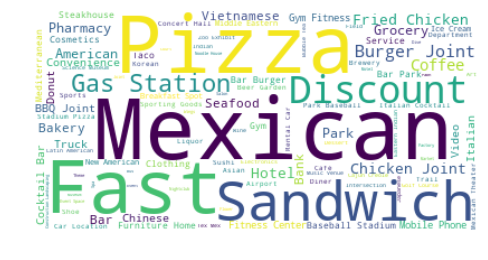

In [120]:
# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

# save the data frame as csv file, and read it as text
hou_venues_sorted.to_csv("hou_venues_sorted.csv")
hou_venues_text = open("hou_venues_sorted.csv", 'r').read()

# add more stopwords to the default set
stopwords = set(STOPWORDS)
stopwords.add('Restaurant')
stopwords.add('Food')
stopwords.add('Place')
stopwords.add('Store')
stopwords.add('Shop')

# build the word cloud
hou_wc = WordCloud(background_color='white',
    max_words=2000,
    stopwords=stopwords)

hou_wc.generate(hou_venues_text)

# show the image
plt.imshow(hou_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Next, let's generate Dallas' word clouds.

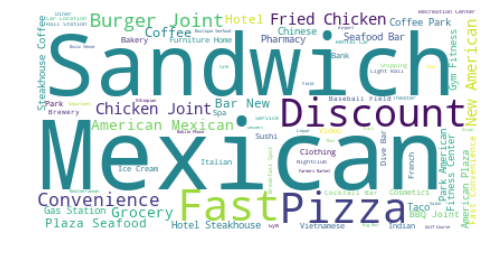

In [124]:
dal_venues_sorted.to_csv("dal_venues_sorted.csv")
dal_venues_text = open("dal_venues_sorted.csv", 'r').read()

# build the word cloud (we use the same stopwords that we used for Houston's case)
dal_wc = WordCloud(background_color='white',
    max_words=2000,
    stopwords=stopwords)

dal_wc.generate(dal_venues_text)

# show the image
plt.imshow(dal_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Obviously, the most popular restaurants in Houston and Dallas are very similar; Mexican, pizza, fast food, and sandwich places are very popular in two cities. Taking a closer look, we can find that the word 'Vietnamese' in Houston's word clouds seems to be a little bigger than the one in Dallas', which may indicate that the ratio of Vietnamese restaurants in Houston is higher. 

# 3. Clustering

## Clustering Houston

#### First, we will try to run k-means to cluster Houston and Dallas' post code areas separately.

In [79]:
# set k, the number of clusters
k=6

# drop the post code column
hou_grouped_clus = hou_grouped.drop("postcode", 1)

# run k-means clustering
kmeans_hou = KMeans(n_clusters=k, random_state=0).fit(hou_grouped_clus)

In [81]:
#add clustering labels
hou_venues_sorted.insert(0, 'Cluster Labels', kmeans_hou.labels_)
hou_merged = df_hou

# merge hou_grouped with hou_venues_sorted to add latitude/longitude for each post code area
hou_merged = hou_merged.join(hou_venues_sorted.set_index('postcode'), on='postcode')
hou_merged.head()

postcode        lat        lng  Cluster Labels 1st Most Common Venue  \
0    77001  29.770000 -95.370000               0          Concert Hall   
1    77002  29.752554 -95.370401               0                 Hotel   
2    77003  29.753611 -95.344241               0                   Bar   
3    77004  29.720903 -95.367784               4           Zoo Exhibit   
4    77005  29.718347 -95.430614               4    Italian Restaurant   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Cocktail Bar          Burger Joint                   Bar   
1  Vietnamese Restaurant                   Bar                  Park   
2     Mexican Restaurant                 Hotel           Beer Garden   
3            Coffee Shop                   Bar                 Trail   
4           Burger Joint   American Restaurant    Mexican Restaurant   

  5th Most Common Venue            6th Most Common Venue  \
0           Pizza Place                            Hotel   
1           Pizza Place                     Burger Joint   
2               Brewery                     Cocktail Bar   
3        Science Museum  Southern / Soul Food Restaurant   
4        Ice Cream Shop                   Cosmetics Shop   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Coffee Shop               Brewery                  Park   
1           Cocktail Bar        Sandwich Place    Mexican Restaurant   
2  Vietnamese Restaurant      Baseball Stadium    Italian Restaurant   
3             Art Museum           Art Gallery   American Restaurant   
4            Coffee Shop            Playground             Bookstore   

  10th Most Common Venue  
0             Steakhouse  
1               Wine Bar  
2                   Park  
3       Sculpture Garden  
4               Creperie

#### Finally, let's visualize the resulting clusters.
#### First, let's get the grographical coordinates of Houston and Dallas.

In [48]:
geolocator = Nominatim(user_agent="TX_explorer")
location = geolocator.geocode("Houston, Texas")
latitude_hou = location.latitude
longitude_hou = location.longitude
print("The geographical coordinate of Houston is {}, {}.".format(latitude_hou, longitude_hou))

location = geolocator.geocode("Dallas, Texas")
latitude_dal = location.latitude
longitude_dal = location.longitude
print("The geographical coordinate of Dallas is {}, {}.".format(latitude_dal, longitude_dal))


The geographical coordinate of Houston is 29.7589382, -95.3676974.
The geographical coordinate of Dallas is 32.7762719, -96.7968559.


In [82]:
# create map
hou_map_clusters = folium.Map(location=[latitude_hou, longitude_hou], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hou_merged['lat'], hou_merged['lng'], hou_merged['postcode'], hou_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(hou_map_clusters)
       
hou_map_clusters

#### Now we have 6 clusters generated by the K-means algorithm. Let's examine them one by one.

### HOU Cluster 1

#### In order to keep this notebook in a readable length, only the first 5 rows are presented here, but the discussion will include every row in the cluster.

In [91]:
print(hou_merged.loc[hou_merged['Cluster Labels']==0, 
               hou_merged.columns[[0] + list(range(4, hou_merged.shape[1]))]].shape)
hou_merged.loc[hou_merged['Cluster Labels']==0, 
               hou_merged.columns[[0] + list(range(4, hou_merged.shape[1]))]].head()

(22, 11)


postcode 1st Most Common Venue  2nd Most Common Venue  \
0     77001          Concert Hall           Cocktail Bar   
1     77002                 Hotel  Vietnamese Restaurant   
2     77003                   Bar     Mexican Restaurant   
9     77010                 Hotel                    Bar   
51    77052                 Hotel                    Bar   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Burger Joint                   Bar           Pizza Place   
1                    Bar                  Park           Pizza Place   
2                  Hotel           Beer Garden               Brewery   
9     Italian Restaurant          Cocktail Bar          Burger Joint   
51          Burger Joint    Italian Restaurant    Mexican Restaurant   

   6th Most Common Venue  7th Most Common Venue    8th Most Common Venue  \
0                  Hotel            Coffee Shop                  Brewery   
1           Burger Joint           Cocktail Bar           Sandwich Place   
2           Cocktail Bar  Vietnamese Restaurant         Baseball Stadium   
9       Baseball Stadium            Music Venue  New American Restaurant   
51                  Park            Pizza Place         Baseball Stadium   

    9th Most Common Venue 10th Most Common Venue  
0                    Park             Steakhouse  
1      Mexican Restaurant               Wine Bar  
2      Italian Restaurant                   Park  
9   Vietnamese Restaurant            Pizza Place  
51           Cocktail Bar               Beer Bar

#### It's obvious that hotels, bars (and cocktail bars), parks and burger joints are the most popular venues in this cluster, which represents the red points in the map. Mexican, Italian, and Vietnamese restaurants are also popular in this area. Obviously, most red points concentrate in the downtown of Houston. 

### HOU Cluster 2

In [94]:
print(hou_merged.loc[hou_merged['Cluster Labels']==1, 
               hou_merged.columns[[0] + list(range(4, hou_merged.shape[1]))]].shape)
hou_merged.loc[hou_merged['Cluster Labels']==1, 
               hou_merged.columns[[0] + list(range(4, hou_merged.shape[1]))]].head()

(22, 11)


postcode 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
13    77014   Fried Chicken Joint              Pharmacy        Discount Store   
15    77016        Discount Store                  Park   Fried Chicken Joint   
20    77021  Fast Food Restaurant   Fried Chicken Joint           Gas Station   
25    77026        Discount Store  Fast Food Restaurant   Fried Chicken Joint   
27    77028        Discount Store   Fried Chicken Joint  Fast Food Restaurant   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
13           Video Store             BBQ Joint       Bubble Tea Shop   
15              Bus Stop  Fast Food Restaurant           Gas Station   
20             BBQ Joint           Pizza Place        Sandwich Place   
25          Burger Joint           Gas Station        Cosmetics Shop   
27   American Restaurant         Grocery Store     Convenience Store   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
13          Noodle House           Golf Course   American Restaurant   
15            Food Truck                  Food                   Spa   
20            Donut Shop        Discount Store            Restaurant   
25             BBQ Joint      Department Store        Sandwich Place   
27          Burger Joint     Mobile Phone Shop                Museum   

   10th Most Common Venue  
13    Rental Car Location  
15      Other Repair Shop  
20              Nightclub  
25     Chinese Restaurant  
27            Bus Station

#### Purple points in the map represent Cluster 2. Fast food restaurants, fried chicken joints, pizza place, discount store, grocery stores and gas stations are the top venues of this cluster. These points seem to spread more equally in the map, which may explain the top types of venues of this cluster, since those venues are the kinds of place that people might visit very often, and they are demanded in almost every area.

### HOU Cluster 3

In [95]:
print(hou_merged.loc[hou_merged['Cluster Labels']==2, 
               hou_merged.columns[[0] + list(range(4, hou_merged.shape[1]))]].shape)
hou_merged.loc[hou_merged['Cluster Labels']==2, 
               hou_merged.columns[[0] + list(range(4, hou_merged.shape[1]))]].head()

(1, 11)


postcode 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
43    77044                  Park               Dog Run                 Trail   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
43           Music Venue                 River           Zoo Exhibit   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
43        Farmers Market  Ethiopian Restaurant         Event Service   

   10th Most Common Venue  
43            Event Space

#### Cluster 3 is the blue point in the map. It only has one row, which can be regarded as an outlier.

### HOU Cluster 4

In [98]:
print(hou_merged.loc[hou_merged['Cluster Labels']==3, 
               hou_merged.columns[[0] + list(range(4, hou_merged.shape[1]))]].shape)
hou_merged.loc[hou_merged['Cluster Labels']==3, 
               hou_merged.columns[[0] + list(range(4, hou_merged.shape[1]))]].head()

(70, 11)


postcode 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
10    77011  Fast Food Restaurant    Mexican Restaurant           Gas Station   
11    77012    Mexican Restaurant        Discount Store           Pizza Place   
12    77013    Mexican Restaurant           Gas Station                 Hotel   
14    77015    Mexican Restaurant  Fast Food Restaurant    Seafood Restaurant   
16    77017        Discount Store            Food Truck    Mexican Restaurant   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
10     Convenience Store                Bakery                   Bar   
11                  Park     Convenience Store              Pharmacy   
12        Discount Store        Sandwich Place              Pharmacy   
14        Discount Store   American Restaurant     Mobile Phone Shop   
16           Gas Station                  Park    Chinese Restaurant   

   7th Most Common Venue 8th Most Common Venue  9th Most Common Venue  \
10              Pharmacy           Video Store            Snack Place   
11        Ice Cream Shop       Harbor / Marina                    Gym   
12         Grocery Store                 Diner                   Park   
14         Big Box Store         Boat or Ferry       Storage Facility   
16     Convenience Store     Mobile Phone Shop  Vietnamese Restaurant   

   10th Most Common Venue  
10    Fried Chicken Joint  
11            Gas Station  
12            Pizza Place  
14    Sporting Goods Shop  
16   Fast Food Restaurant

#### Cluster 4 is composed of the light blue-green points in the maps. Mexican restaurants and fast food restaurants are the most popular venues in this cluster. Some other kinds of venues in everyday demand such as gas stations, grocery stores, and discount stores are also common in this cluster.

### HOU Cluster 5

In [100]:
print(hou_merged.loc[hou_merged['Cluster Labels']==4, 
               hou_merged.columns[[0] + list(range(4, hou_merged.shape[1]))]].shape)
hou_merged.loc[hou_merged['Cluster Labels']==4, 
               hou_merged.columns[[0] + list(range(4, hou_merged.shape[1]))]].head()

(64, 11)


postcode 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
3    77004           Zoo Exhibit           Coffee Shop                   Bar   
4    77005    Italian Restaurant          Burger Joint   American Restaurant   
5    77006           Coffee Shop                   Bar    Mexican Restaurant   
6    77007                   Bar                 Trail    Mexican Restaurant   
7    77008           Coffee Shop    Mexican Restaurant    Italian Restaurant   

  4th Most Common Venue  5th Most Common Venue  \
3                 Trail         Science Museum   
4    Mexican Restaurant         Ice Cream Shop   
5              Wine Bar  Vietnamese Restaurant   
6   American Restaurant                   Park   
7                   Bar           Burger Joint   

             6th Most Common Venue    7th Most Common Venue  \
3  Southern / Soul Food Restaurant               Art Museum   
4                   Cosmetics Shop              Coffee Shop   
5                     Cocktail Bar           Breakfast Spot   
6                              Gym         Sushi Restaurant   
7                              Gym  New American Restaurant   

  8th Most Common Venue 9th Most Common Venue     10th Most Common Venue  
3           Art Gallery   American Restaurant           Sculpture Garden  
4            Playground             Bookstore                   Creperie  
5           Beer Garden    Italian Restaurant  Cajun / Creole Restaurant  
6           Pizza Place            Steakhouse                     Museum  
7           Beer Garden        Sandwich Place       Gym / Fitness Center

#### Cluster 5 consists of the light green points in the map. There are many different kinds of restaurants in this cluster; Mexican  and Vietnamese restaurants are still popular, but when compared to other clusters, this cluster obviously has more middle eastern and Mediterranean restaurants. We can also see Indian, Chinese, Italian, and Japanese restaurants appear many times in this cluster.

### HOU Cluster 6

In [101]:
print(hou_merged.loc[hou_merged['Cluster Labels']==5, 
               hou_merged.columns[[0] + list(range(4, hou_merged.shape[1]))]].shape)
hou_merged.loc[hou_merged['Cluster Labels']==5, 
               hou_merged.columns[[0] + list(range(4, hou_merged.shape[1]))]]

(1, 11)


postcode 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
49    77050           Golf Course                   Bar        Scenic Lookout   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
49                  Park           Zoo Exhibit     Electronics Store   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
49         Event Service           Event Space            Eye Doctor   

   10th Most Common Venue  
49            Fabric Shop

#### Cluster 6 is the orange point in the map. Since it only has one row, we can consider it an outlier.

## Clustering Dallas

In [154]:
# set k, the number of clusters
k=5

# drop the post code column
dal_grouped_clus = dal_grouped.drop("postcode", 1)

# run k-means clustering
kmeans_dal = KMeans(n_clusters=k, random_state=0).fit(dal_grouped_clus)

In [156]:
#add clustering labels
dal_venues_sorted.insert(0, 'Cluster Labels', kmeans_dal.labels_)
dal_merged = df_dal

# merge dal_grouped with dal_venues_sorted to add latitude/longitude for each post code area
dal_merged = dal_merged.join(dal_venues_sorted.set_index('postcode'), on='postcode')
dal_merged.head()

postcode        lat        lng  Cluster Labels 1st_Most_Common_Venue  \
0    75201  32.786330 -96.796253               1   American Restaurant   
1    75202  32.777469 -96.804288               1                 Hotel   
2    75203  32.743300 -96.786879               2    Seafood Restaurant   
3    75204  32.799475 -96.786879               3           Coffee Shop   
4    75205  32.832584 -96.797592               3    Mexican Restaurant   

  2nd_Most_Common_Venue 3rd_Most_Common_Venue    4th_Most_Common_Venue  \
0                   Bar           Coffee Shop               Steakhouse   
1           Coffee Shop            Steakhouse                     Park   
2     Convenience Store            Restaurant                      Bar   
3   American Restaurant          Burger Joint              Pizza Place   
4                  Park     French Restaurant  New American Restaurant   

             5th_Most_Common_Venue 6th_Most_Common_Venue  \
0          New American Restaurant                 Hotel   
1          New American Restaurant    Mexican Restaurant   
2  Southern / Soul Food Restaurant        Scenic Lookout   
3                             Park      Sushi Restaurant   
4                   Sandwich Place           Pizza Place   

  7th_Most_Common_Venue 8th_Most_Common_Venue 9th_Most_Common_Venue  \
0          Burger Joint    Mexican Restaurant          Cocktail Bar   
1    Seafood Restaurant   American Restaurant          Cocktail Bar   
2            Taco Place        Discount Store  Fast Food Restaurant   
3    Seafood Restaurant       Thai Restaurant    Mexican Restaurant   
4              Boutique    Seafood Restaurant         Grocery Store   

  10th_Most_Common_Venue  
0     Seafood Restaurant  
1                  Plaza  
2            Gas Station  
3           Cocktail Bar  
4                    Spa

In [157]:
# create map
dal_map_clusters = folium.Map(location=[latitude_dal, longitude_dal], zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dal_merged['lat'], dal_merged['lng'], dal_merged['postcode'], dal_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(dal_map_clusters)
       
dal_map_clusters

#### Now we have 5 clusters generated by the K-means algorithm. Let's examine them one by one.

### DAL Cluster 1

#### In order to keep this notebook in a readable length, only the first 5 rows are presented here, but the discussion will include every row in the cluster.

In [159]:
print(dal_merged.loc[dal_merged['Cluster Labels']==0, 
               dal_merged.columns[[0] + list(range(4, dal_merged.shape[1]))]].shape)
dal_merged.loc[dal_merged['Cluster Labels']==0, 
               dal_merged.columns[[0] + list(range(4, dal_merged.shape[1]))]]

(5, 11)


postcode 1st_Most_Common_Venue    2nd_Most_Common_Venue  \
34     75236  Fast Food Restaurant               Campground   
38     75241  Fast Food Restaurant              Gas Station   
45     75249                  Park  State / Provincial Park   
114    75050           Gas Station        Convenience Store   
118    75054                  Pool                      Gym   

    3rd_Most_Common_Venue 4th_Most_Common_Venue 5th_Most_Common_Venue  \
34                  Trail             Gun Range               Theater   
38              BBQ Joint            Truck Stop                   Spa   
45   Fast Food Restaurant     Recreation Center              Mountain   
114                  Park         Garden Center                 Trail   
118          Home Service            Campground            Playground   

    6th_Most_Common_Venue 7th_Most_Common_Venue 8th_Most_Common_Venue  \
34         Baseball Field           Zoo Exhibit           Fabric Shop   
38                  Hotel        Sandwich Place   Fried Chicken Joint   
45                  Trail       Nature Preserve         Big Box Store   
114            Skate Park       Harbor / Marina        Clothing Store   
118                 Trail                  Lake           Golf Course   

    9th_Most_Common_Venue 10th_Most_Common_Venue  
34         Farmers Market                  Field  
38      Convenience Store      Mobile Phone Shop  
45                  Beach        Harbor / Marina  
114        Baseball Field              Gun Range  
118  Fast Food Restaurant                Brewery

#### Cluster 1 consists of the red points in the map. There are many kinds of venues and it is hard to tell which types of venues are more popular.

### DAL Cluster 2

In [162]:
print(dal_merged.loc[dal_merged['Cluster Labels']==1, 
               dal_merged.columns[[0] + list(range(4, dal_merged.shape[1]))]].shape)
dal_merged.loc[dal_merged['Cluster Labels']==1, 
               dal_merged.columns[[0] + list(range(4, dal_merged.shape[1]))]].head()

(32, 11)


postcode 1st_Most_Common_Venue 2nd_Most_Common_Venue 3rd_Most_Common_Venue  \
0     75201   American Restaurant                   Bar           Coffee Shop   
1     75202                 Hotel           Coffee Shop            Steakhouse   
19    75221                 Hotel            Steakhouse   American Restaurant   
20    75222                 Hotel            Steakhouse           Coffee Shop   
39    75242                 Hotel           Coffee Shop            Steakhouse   

   4th_Most_Common_Venue    5th_Most_Common_Venue    6th_Most_Common_Venue  \
0             Steakhouse  New American Restaurant                    Hotel   
1                   Park  New American Restaurant       Mexican Restaurant   
19           Coffee Shop                      Bar  New American Restaurant   
20                  Park      American Restaurant                    Plaza   
39   American Restaurant                     Park  New American Restaurant   

   7th_Most_Common_Venue 8th_Most_Common_Venue    9th_Most_Common_Venue  \
0           Burger Joint    Mexican Restaurant             Cocktail Bar   
1     Seafood Restaurant   American Restaurant             Cocktail Bar   
19    Mexican Restaurant    Seafood Restaurant                    Plaza   
20    Seafood Restaurant                   Bar  New American Restaurant   
39    Mexican Restaurant                 Plaza       Seafood Restaurant   

   10th_Most_Common_Venue  
0      Seafood Restaurant  
1                   Plaza  
19      French Restaurant  
20     Mexican Restaurant  
39         Farmers Market

#### Cluster 2 consists of the purple points in the map. Purple points are very concentrated in some areas; this makes the their areas within a radius of 2500 meters highly overlapped. Thus, many postal code areas have the identical top 10 venues. Although cluster 2 only represents some small areas, we can still see that the most popular venues in this cluster are hotels, bars, and coffee shops.

### DAL /Cluster 3

In [166]:
print(dal_merged.loc[dal_merged['Cluster Labels']==2, 
               dal_merged.columns[[0] + list(range(4, dal_merged.shape[1]))]].shape)
dal_merged.loc[dal_merged['Cluster Labels']==2, 
               dal_merged.columns[[0] + list(range(4, dal_merged.shape[1]))]].head()

(51, 11)


postcode 1st_Most_Common_Venue         2nd_Most_Common_Venue  \
2     75203    Seafood Restaurant             Convenience Store   
9     75210   Fried Chicken Joint  Theme Park Ride / Attraction   
10    75211           Pizza Place             Convenience Store   
11    75212                 Hotel          Fast Food Restaurant   
13    75215                  Park                Discount Store   

   3rd_Most_Common_Venue 4th_Most_Common_Venue  \
2             Restaurant                   Bar   
9                   Park     Recreation Center   
10  Fast Food Restaurant        Discount Store   
11   Fried Chicken Joint    Chinese Restaurant   
13   American Restaurant           Music Venue   

              5th_Most_Common_Venue 6th_Most_Common_Venue  \
2   Southern / Soul Food Restaurant        Scenic Lookout   
9                    Discount Store    Light Rail Station   
10                       Taco Place          Liquor Store   
11                   Discount Store           Pizza Place   
13                   Sandwich Place    Light Rail Station   

   7th_Most_Common_Venue         8th_Most_Common_Venue  \
2             Taco Place                Discount Store   
9    American Restaurant                   Zoo Exhibit   
10    Mexican Restaurant                Sandwich Place   
11        Baseball Field                   Coffee Shop   
13             Nightclub  Theme Park Ride / Attraction   

              9th_Most_Common_Venue  10th_Most_Common_Venue  
2              Fast Food Restaurant             Gas Station  
9   Southern / Soul Food Restaurant           Grocery Store  
10                        BBQ Joint          Clothing Store  
11                    Grocery Store            Burger Joint  
13                          Dog Run  Thrift / Vintage Store

#### Cluster 3 is composed of the blue points in the map. This cluster seems to have many generally popular places such as Mexican and fast food restaurants, pizza place, convenience and discount stores. However, in the area of 75378, the top 1 venue is Korean restaurant, which does not appear often in the data. That area may be the Korean town of Dallas.

### Cluster 4

In [167]:
print(dal_merged.loc[dal_merged['Cluster Labels']==3, 
               dal_merged.columns[[0] + list(range(4, dal_merged.shape[1]))]].shape)
dal_merged.loc[dal_merged['Cluster Labels']==3, 
               dal_merged.columns[[0] + list(range(4, dal_merged.shape[1]))]].head()

(50, 11)


postcode 1st_Most_Common_Venue 2nd_Most_Common_Venue 3rd_Most_Common_Venue  \
3    75204           Coffee Shop   American Restaurant          Burger Joint   
4    75205    Mexican Restaurant                  Park     French Restaurant   
5    75206           Pizza Place                   Bar           Coffee Shop   
6    75207            Steakhouse    Mexican Restaurant           Coffee Shop   
7    75208    Mexican Restaurant           Coffee Shop   American Restaurant   

     4th_Most_Common_Venue 5th_Most_Common_Venue    6th_Most_Common_Venue  \
3              Pizza Place                  Park         Sushi Restaurant   
4  New American Restaurant        Sandwich Place              Pizza Place   
5       Mexican Restaurant                   Spa  New American Restaurant   
6       Seafood Restaurant    Italian Restaurant             Burger Joint   
7        Convenience Store             Gastropub                    Diner   

  7th_Most_Common_Venue    8th_Most_Common_Venue 9th_Most_Common_Venue  \
3    Seafood Restaurant          Thai Restaurant    Mexican Restaurant   
4              Boutique       Seafood Restaurant         Grocery Store   
5     French Restaurant         Sushi Restaurant            Taco Place   
6                 Hotel  New American Restaurant               Brewery   
7            Taco Place           Sandwich Place          Burger Joint   

  10th_Most_Common_Venue  
3           Cocktail Bar  
4                    Spa  
5     Italian Restaurant  
6    Japanese Restaurant  
7              Gift Shop

#### Cluster 4 consists of the light green points in the map. Mexican restaurants and Taco places are very popular in this cluster. There are some French restaurants in this cluster, which are rarely in other clusters of Dallas.

### Cluster 5

In [169]:
print(dal_merged.loc[dal_merged['Cluster Labels']==4, 
               dal_merged.columns[[0] + list(range(4, dal_merged.shape[1]))]].shape)
dal_merged.loc[dal_merged['Cluster Labels']==4, 
               dal_merged.columns[[0] + list(range(4, dal_merged.shape[1]))]]

(1, 11)


postcode 1st_Most_Common_Venue 2nd_Most_Common_Venue  \
131    75181     Convenience Store        Farmers Market   

    3rd_Most_Common_Venue       4th_Most_Common_Venue 5th_Most_Common_Venue  \
131           Coffee Shop  Construction & Landscaping   Fried Chicken Joint   

    6th_Most_Common_Venue 7th_Most_Common_Venue 8th_Most_Common_Venue  \
131     French Restaurant           Fabric Shop  Fast Food Restaurant   

    9th_Most_Common_Venue      10th_Most_Common_Venue  
131                 Field  Financial or Legal Service

#### Cluster 5 is the orange point in the map. It only has one row, so we can regard it as an outlier.